# Homework 3 


#### PHYS247-Spring 2020 - Student : Silvia Cabellos


### Problem 1: Homework 2!

#### The first part of the Homework 3 is just to recreate some results from Homework 2 that will be needed to check consistency of the results and answer some of the questions 


#### We start by importing some packages, loading the tweet data and reproducing the posteriors that will be used in HW3 


In [1]:
import cvxopt 

ModuleNotFoundError: No module named 'cvxopt'

In [29]:
%matplotlib inline

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm

sns.set_style('white')
sns.set_context('talk')

np.random.seed(123)

In [30]:
tweet=pd.read_csv(r'C:\Users\scabellos\OneDrive - Urban Science\User Documents\MastersDegree\AppliedDataScience\Homework2\tweet_counts.csv')

In [31]:
k=tweet['count'].values
w=tweet['week'].values

In [33]:
average_λ=np.average(k) 
α=1/average_λ
α # this is the prior 

0.025793650793650796

In [34]:
λ1_est=np.linspace(25,50,50) # variable space to look for \lambda1 
λ2_est=np.linspace(25,50,50) # variable space to look for \lambda2
Ws_est=np.arange(1,53,1) # defined at the begining on the homework , space for the weeks. 

In [35]:
# model space for λ1,λ1,Ws
λ1_est_mesh,λ2_est_mesh, Ws_est_mesh,=np.meshgrid(λ1_est,λ2_est,Ws_est)

In [36]:
Ws_est_mesh.shape

(50, 50, 52)

In [37]:
#  define the exponential distribution 
Exponential=lambda λ,α: α*np.exp(-λ*α)
Exponential=np.vectorize(Exponential)

# first define the poisson distribution 
Poisson=lambda k,λ: (λ**k)*np.exp(-λ)/np.math.factorial(k)
Poisson=np.vectorize(Poisson)

In [38]:
def Posterior(λ1,λ2,W_s):
    P=1
    for i in k[w<W_s]:
            P=P*Poisson(i,λ1)*Exponential(λ1,α)
    for j in k[w>=W_s]:
            P=P*Poisson(j,λ2)*Exponential(λ2,α)
    return(P)

In [39]:
Posterior=np.vectorize(Posterior)

In [40]:
Post=Posterior(λ1_est_mesh, λ2_est_mesh, Ws_est_mesh) # analytical results 

In [41]:
Post_λ1=np.sum(np.sum(Post,axis=2).T,axis=1)/np.trapz(np.sum(np.sum(Post,axis=2).T,axis=1),λ1_est)
Post_λ2=np.sum(np.sum(Post,axis=2),axis=1)/np.trapz(np.sum(np.sum(Post,axis=2),axis=1),λ2_est)

# Homework 3 starts here 


## a) 
### Write a Python code to implement the Metropolis-Hastings algorithm for the twitter problem in homework 2 and and the posterior distributions for $\lambda_1$, $\lambda_2$ and Ws. 

First, we are going to define some functions 

In [42]:
def log_posterior(data,param):
    k,w=data
    lamb1,lamb2,W_s=param
    
    P=0
    
    for i in k[w<W_s]:
        P=P+np.log(Poisson(i,lamb1)*α*np.exp(-α*lamb1))

    for j in k[w>=W_s]:
        P=P+np.log(Poisson(j,lamb2)*α*np.exp(-α*lamb2))
        
    return(P)

For the Metropolis sampler, we are just to take a sample from a normal distribution centered around your current  average value with a certain standard deviation (proposal step ) that will determine how far are the proposed jumps:

In [43]:
def MCMC(log_Posterior,data,initial,step_cov,n_iteration):
    param1=np.array(initial)
    sample=np.array(initial)
    for j in range(n_iteration):
        log_Posterior_i=log_Posterior(data,param1)
        #update the location
        param2=np.random.multivariate_normal(param1,step_cov)
        #find new posterior
        log_Posterior_f=log_Posterior(data,param2)
        # generate a random number between 0 and 1
        rand=np.random.rand()
        if log_Posterior_f-log_Posterior_i>np.log(rand):
            sample=np.vstack((sample,param2))
            param1=param2[:]
        else:
            sample=np.vstack((sample,param1))
    return(sample)  

In [60]:
D=MCMC(log_posterior,data=[k,w],initial=[20,20,20],step_cov=[[0.25,0,0],[0,0.25,0],[0,0,0.5]],n_iteration=10000)

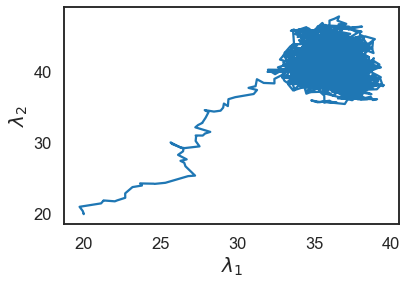

In [874]:
plt.plot(D.T[0],D.T[1])
plt.xlabel("$\lambda_1$",fontsize=20)
plt.xlabel("$\lambda_1$",fontsize=20)
plt.ylabel("$\lambda_2$",fontsize=20)

plt.show()

#### How do the initial value of parameters (the starting point) and number of iteration affect your results?

If we initialize the parameters using the mean, it will converge much faster 

In [62]:
D_optimized=MCMC(log_posterior,data=[k,w],initial=[np.mean(D.T[0]),np.mean(D.T[1]),round(np.mean(D.T[2]))],step_cov=[[0.25,0,0],[0,0.25,0],[0,0,0.5]],n_iteration=10000)

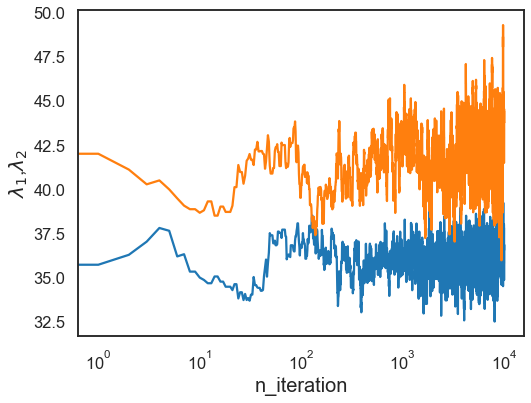

In [63]:
fig = plt.figure(figsize=(8,6))
plt.plot(D_optimized.T[0])
plt.plot(D_optimized.T[1])

plt.ylabel("$\lambda_1$,$\lambda_2$",fontsize=20)
plt.xlabel("n_iteration",fontsize=20)
#plt.vlines(100,20,40,color='red',linewidth=5)
plt.xscale('log')

If we optimize setting up the initial parameters to be the median of $\lambda_1$ , $\lambda_2$  and W, then the variance is lower as it converges quicker around the initial values. 

The two samples ( D and D_Optimized ) can be compared in the following chart 

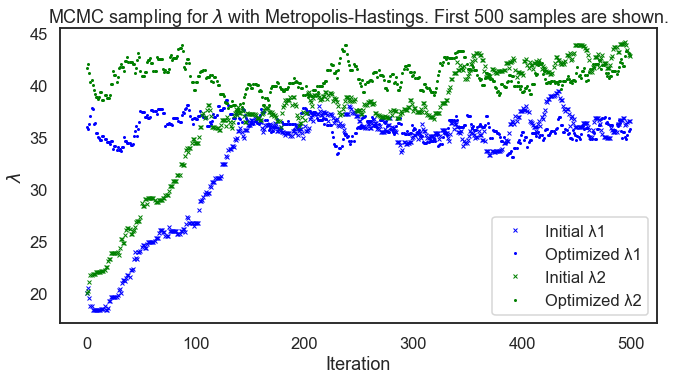

In [64]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(2,1,1)

ax.plot( D.T[0][0:500], 'bx', label='Initial λ1', markersize=4)
ax.plot( D_optimized.T[0][0:500], 'b.', label='Optimized λ1',markersize=4)
ax.plot( D.T[1][0:500], 'gx', label='Initial λ2',markersize=4)
ax.plot( D_optimized.T[1][0:500], 'g.', label='Optimized λ2',markersize=4)


ax.set_xlabel("Iteration")
ax.set_ylabel("$\lambda$")
ax.set_title("MCMC sampling for $\lambda$ with Metropolis-Hastings. First 500 samples are shown.")
#ax.grid()
ax.legend()
plt.tight_layout()
plt.show()




## b) 
### Are the posteriors consistent with those you found in the previous homework?

If we look at the distribution of the samples, they look similar to the posteriors calcuated in Homework 2. 

If we plot the posteriors using the samples drawn from MCMC algorithm , we can check some statistics ( Mean , Median and Mode ) to check consistency 

Below  are some statistics on λ1
Mean for MCMC Optimized λ1 is : 36.1 
Standard Deviation for MCMC Optimized λ1 is : 1.08 
Mode for MCMC Optimized λ1  is : 35.0
Mode for Original λ1 is : 35.7
  
Below  are some statistics on λ2
Mean for MCMC Optimized λ2 is : 41.9 
Standard Deviation for MCMC Optimized λ2  is : 1.78 
Mode for MCMC Optimized λ2  is : 43.4
Mode for Original λ2 is : 41.3


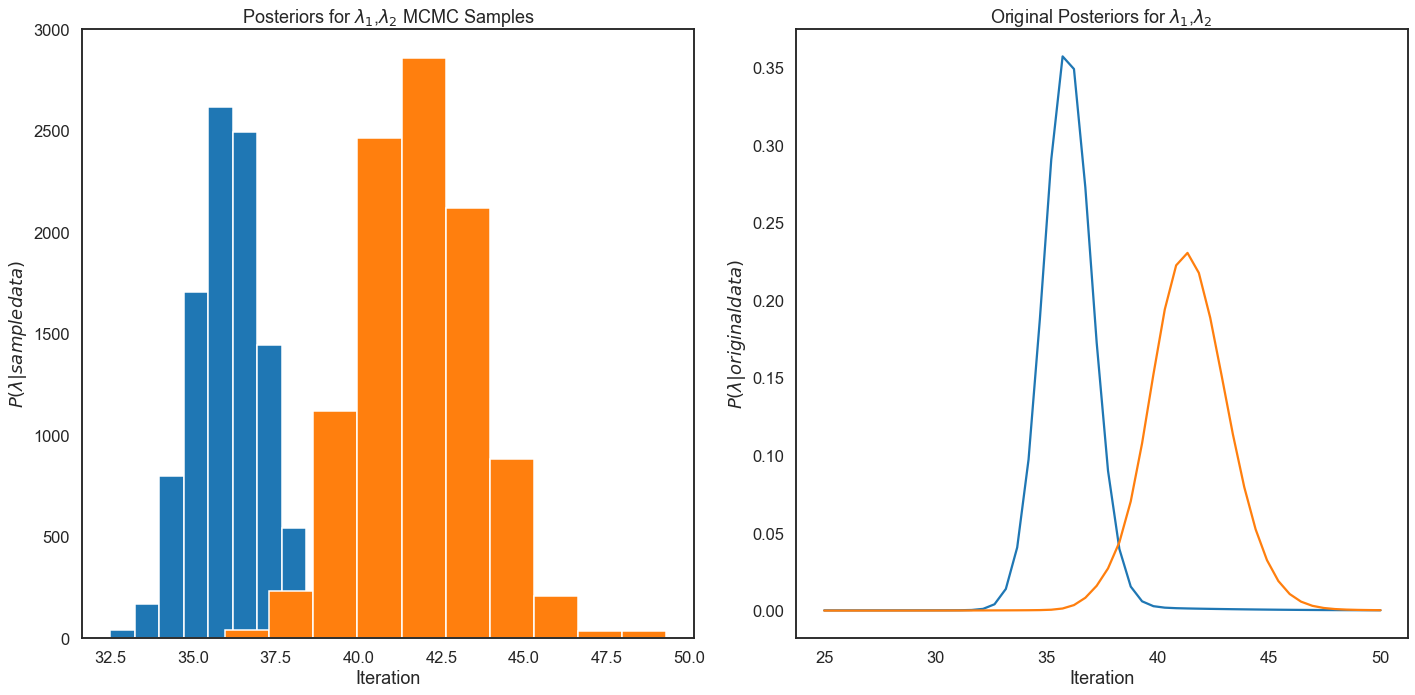

In [65]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,2,1)
ax.hist(D_optimized.T[0],label='λ1')
ax.hist(D_optimized.T[1],label='λ2')
ax.set_title("Posteriors for $\lambda_1$,$\lambda_2$ MCMC Samples ")
ax.set_ylabel("$P(λ|sample data)$")
ax.set_xlabel("Iteration")
ax = fig.add_subplot(1,2,2)
ax.plot(λ1_est,Post_λ1,label='$\lambda_1$')
ax.plot(λ2_est,Post_λ2,label='$\lambda_2$')
ax.set_ylabel('$P(λ|original data)$')
ax.set_xlabel("Iteration")
ax.set_title("Original Posteriors for $\lambda_1$,$\lambda_2$ ")
fig.tight_layout()

Stats_λ1 ="Below  are some statistics on λ1"
print("\033[1m" +Stats_λ1+ "\033[0m")
print('Mean for MCMC Optimized λ1 is : {:.3} '.format(np.mean(D_optimized.T[0])))
print('Standard Deviation for MCMC Optimized λ1 is : {:.3} '.format(np.std(D_optimized.T[0])))
print('Mode for MCMC Optimized λ1  is : {:.3}'.format(max((D_optimized.T[0].tolist().count(item), item) for item in set(D_optimized.T[0].tolist()))[1]))
print('Mode for Original λ1 is : {:.3}'.format(λ1_est[np.argmax(Post_λ1)]))


print("  ")
Stats_λ2 ="Below  are some statistics on λ2"
print("\033[1m" +Stats_λ2+ "\033[0m")
print('Mean for MCMC Optimized λ2 is : {:.3} '.format(np.mean(D_optimized.T[1])))
print('Standard Deviation for MCMC Optimized λ2  is : {:.3} '.format(np.std(D_optimized.T[1])))
print('Mode for MCMC Optimized λ2  is : {:.3}'.format(max((D_optimized.T[1].tolist().count(item), item) for item in set(D_optimized.T[1].tolist()))[1]))
print('Mode for Original λ2 is : {:.3}'.format(λ2_est[np.argmax(Post_λ2)]))
# mode_ = max((D_optimized.T[0].tolist().count(item), item) for item in set(D_optimized.T[0].tolist()))[1]
# mode_ 



## c)
### As you did in part g of homework 2, find P(($\lambda_2$- $\lambda_1$) > 5), the probability that Bob's weekly tweet counts have increased by five at some point.

#### First, we are going to calculate the difference of our lambdas in the sample, and then we can see how many of those are >5 and compare this probability to the one obtained in HW2 


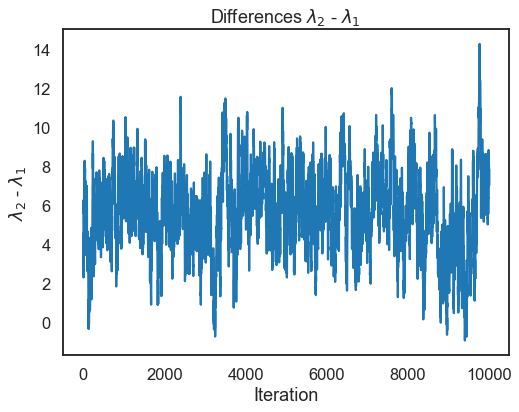

In [66]:
fig = plt.figure(figsize=(8,6))
p=(D_optimized.T[1]-D_optimized.T[0])
plt.plot(p,label='$\lambda_1$')
plt.xlabel("Iteration")
plt.ylabel("$\lambda_2$ - $\lambda_1$ ")
plt.title("Differences $\lambda_2$ - $\lambda_1$ ")
plt.show()


In [67]:
p_above5=[]
for i in p:
    if i>5:
        p_above5.append(i)       

In [68]:
print('The P(λ2- λ2)>5 = {:.3}%'.format(100*len(p_above5)/len(p)))
print('Which is similar to the 63% probability found in Homework2')

The P(λ2- λ2)>5 = 65.1%
Which is similar to the 63% probability found in Homework2


## Problem 2: K-means Clustering

#### In this problem we want to implement K-means clustering based on Lloyd's algorithm. The algorithm is as follows:

#### 1- Start with k centers.

#### 2- Cluster each point with the center nearest to it.

#### 3- Find the centroid of each cluster and replace the set of old centers with the centroids.

#### 4- Repeat the above two steps until the centers converge.


## a) 
### Write a python function that takes data points with two features (two dimensional data) and a number of clusters and returns partitioned data. Consider that the data points are located in Euclidean space.

In [1]:
from sklearn.datasets import make_blobs
X,Y = make_blobs(n_samples=500, cluster_std=0.8, centers=3, n_features=3, random_state=0)

In [2]:
m=X.shape[0] #number of examples #500
n=X.shape[1] #number of features. Here n=3

In [5]:
import numpy as np 
import random 

# here we can initialize our cluster centroids 
K=3 # we start with number of clusters = 3 

centroids=np.array([]).reshape(n,0)  
for i in range(K):
    rand=random.randint(0,m-1)
    centroids=np.c_[centroids,X[rand]] # the function c_ Translates slice objects to concatenation along the second axis.

In [6]:
# Here we calculate the euclidean distance and take the minimum 

distance=np.array([]).reshape(m,0)
for k in range(K):
    tempDist=np.sum((X-centroids[:,k])**2,axis=1)
    distance=np.c_[distance,tempDist]
C=np.argmin(distance,axis=1)+1

In [7]:
Y={}     #create a dictionary for each point and assign it one centroid 
for k in range(K):
    Y[k+1]=np.array([]).reshape(3,0)
for i in range(m):
    Y[C[i]]=np.c_[Y[C[i]],X[i]] 
for k in range(K):
    Y[k+1]=Y[k+1].T
for k in range(K):
     centroids[:,k]=np.mean(Y[k+1],axis=0)

In [8]:
Output={}
for i in range(100):
     #here we calculate the euclidean distance and take the minimum 
    distance=np.array([]).reshape(m,0)
    for k in range(K):
        tempDist=np.sum((X-centroids[:,k])**2,axis=1)
        distance=np.c_[distance,tempDist]
    C=np.argmin(distance,axis=1)+1
     # #create a dictionary for each point and assign it one centroid 
    Y={}
    for k in range(K):
        Y[k+1]=np.array([]).reshape(3,0)
    for i in range(m):
        Y[C[i]]=np.c_[Y[C[i]],X[i]]
    for k in range(K):
        Y[k+1]=Y[k+1].T
    for k in range(K):
        centroids[:,k]=np.mean(Y[k+1],axis=0)
    Output=Y

#### Putting everything together in a function 

In [9]:
def Kmeans_Clustering(X,k):
    """
   This function has 4 parts :
     1. Initialize k clusters ( randomly)
     2. Caculate the distance for each point to the clusters centroids and assign it to centroid that gives mininum distance
     3. Replace centroids with new centroids according to the min average distance.  
     4. Iterate that over 100 iterations until the centroids dont change (converge)
     
    """

    m=X.shape[0] #number of examples #500
    n=X.shape[1] #number of features. Here n=3
    
 # 1. We can initialize our cluster centroids 

    centroids=np.array([]).reshape(n,0)  
    for i in range(K):
        rand=random.randint(0,m-1)
        centroids=np.c_[centroids,X[rand]] 
        
  #4 this is the final iteration. For each iteration we do the following 

    Partition={}
    for i in range(100):
     #Calculate the distance and take the minimum 
        distance=np.array([]).reshape(m,0)
        for k in range(K):
            tmp_distance=np.sum((X-centroids[:,k])**2,axis=1)
            distance=np.c_[distance,tmp_distance]
        C=np.argmin(distance,axis=1)+1
     # #create a dictionary for each point and assign it one centroid 
        Y={}
        for k in range(K):
            Y[k+1]=np.array([]).reshape(3,0)
        for i in range(m):
            Y[C[i]]=np.c_[Y[C[i]],X[i]]
        for k in range(K):
            Y[k+1]=Y[k+1].T
        for k in range(K):
            centroids[:,k]=np.mean(Y[k+1],axis=0)
        Partition=Y
    return(Partition)  

## b) 
### Considering 3 clusters, apply your function in part a) to the dataset you have created.

In [10]:
Kmeans_Clustering(X,3)

{1: array([[ 0.02913978, -2.54171761,  2.29810053],
        [ 0.96381813, -0.70884929,  1.73464089],
        [ 1.86702243, -2.12071944,  3.7967196 ],
        [-1.04221339, -1.32471572,  2.95471817],
        [ 0.84007803, -1.47198163,  3.85033794],
        [ 0.0485752 , -0.98679737,  3.64899453],
        [ 1.5737173 , -1.99425639,  2.49388037],
        [ 0.6757893 , -1.90461303,  2.76961855],
        [ 0.99687268, -0.79858735,  3.3540183 ],
        [ 0.30080671, -2.63358351,  2.68796985],
        [ 0.97295514, -1.22127336,  1.47724137],
        [ 0.215643  , -1.21752009,  3.6464738 ],
        [ 1.18738491, -1.85770087,  4.15019339],
        [ 1.64756758, -1.02951133,  1.57318676],
        [ 0.43615396, -0.62071104,  3.31721522],
        [ 0.15342066, -0.81571992,  4.27425173],
        [ 0.97173644, -2.54780627,  3.42557704],
        [ 0.70705978, -1.26169749,  2.22782235],
        [ 0.14753425, -1.97755204,  3.632493  ],
        [-0.2207709 , -2.34054168,  2.04638559],
        [ 0.69824

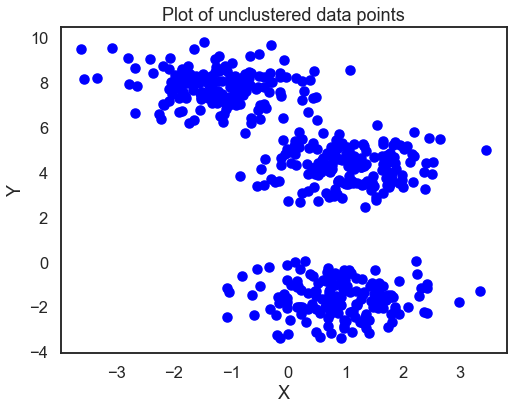

In [20]:
fig = plt.figure(figsize=(8,6))
plt.scatter(X[:,0],X[:,1],c='b')

#plt.legend()
plt.title('Plot of unclustered data points')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

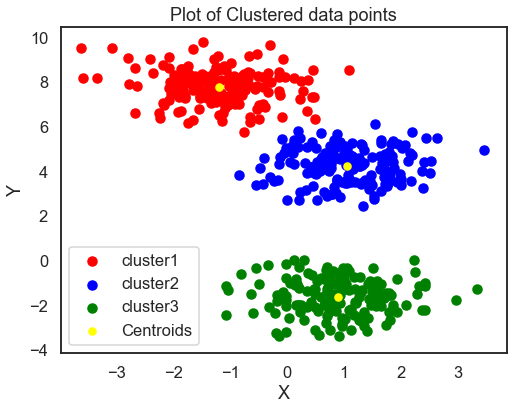

In [25]:
fig = plt.figure(figsize=(8,6))
color=['red','blue','green']
labels=['cluster1','cluster2','cluster3']
for k in range(K):
    plt.scatter(Output[k+1][:,0],Output[k+1][:,1],c=color[k],label=labels[k])
plt.scatter(centroids[0,:],centroids[1,:],s=50,c='yellow',label='Centroids')
plt.title('Plot of Clustered data points')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

## c) 
### Here we knew the number of clusters, but this is not the case in real problems.Explain a method where we can determine optimal number of clusters in K-means algorithm.

So how do we find the appropriate K?
 
The answer lies in the fact that for every data point, it’s cluster center should be the nearest or in other words “Sum of squares of distances of every data point from its corresponding cluster centroid should be as minimum as possible” 

When the number of clusters increases, the centroids are closer to the clusters centroids. The improvements will decline, at some point rapidly, creating the elbow shape. 
 
So our goal is to choose a small value of k that still has a low "Sum of Square Distances", and the elbow usually represents where we start to have diminishing returns by increasing k.
 

## d) 
### Apply your method in part c) to the data you have generated and verify that the optimal number of the cluster for part b is three.

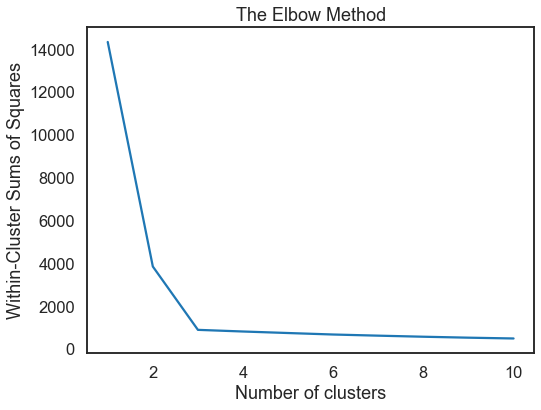

In [28]:
#lets implement the same algorithm using sklearn libraries
# Using the elbow method to find the optimal number of clusters

fig = plt.figure(figsize=(8,6)) 
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i,random_state = 42) #init = 'k-means++',
    kmeans.fit(X)
    wcss.append(kmeans.inertia_) 
#Inertia is the sum of squared error for each cluster. 
#Therefore the smaller the inertia the denser the cluster(closer together all the points are)

plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Within-Cluster Sums of Squares')
plt.show()